# Homework 6: Filtering and Flow

This assignment explores the use of separable convolutions, the Fourier transform to compute a convolution, and the estimation of optical flow.

# Setup Environment

In [1]:
# if 'google.colab' in str(get_ipython()):
#   !pip -q install mediapy

In [2]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

from skimage import data, img_as_float32
from skimage.color import rgb2gray
from skimage.transform import resize, downscale_local_mean, warp

from skimage.registration import optical_flow_ilk

import mediapy as mp
from skimage.filters import sobel_h, sobel_v

## Helpful Function(s) and Global Variables


In [3]:
#@title Plotting Code
def plot_quiver(ax, flow, spacing, margin=0, **kwargs):
    """Plots less dense quiver field.

    https://stackoverflow.com/questions/61943240/quiver-plot-with-optical-flow
    Args:
        ax: Matplotlib axis
        flow: motion vectors
        spacing: space (px) between each arrow in grid
        margin: width (px) of enclosing region without arrows
        kwargs: quiver kwargs (default: angles="xy", scale_units="xy")
    """
    h, w, _ = flow.shape

    nx = int((w - 2 * margin) / spacing)
    ny = int((h - 2 * margin) / spacing)

    x = np.linspace(margin, w - margin - 1, nx, dtype=np.int64)
    y = np.linspace(margin, h - margin - 1, ny, dtype=np.int64)

    flow = flow[np.ix_(y, x)]
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    kwargs = {**dict(angles="xy", scale_units="xy"), **kwargs}
    ax.quiver(x, y, u, v, **kwargs)

    ax.set_ylim(sorted(ax.get_ylim(), reverse=True))
    ax.set_aspect("equal")


np.set_printoptions(precision=3,suppress=True)

# define a few colormaps for consistency
C_IM = 'gray';
C_IMf = 'plasma';
C_KE = C_IMf;
C_FFT = 'viridis';


## Defining Image Filters

We consider three commonly used filters Gaussian, Difference of Gaussians (x), Difference of Gaussians (y).

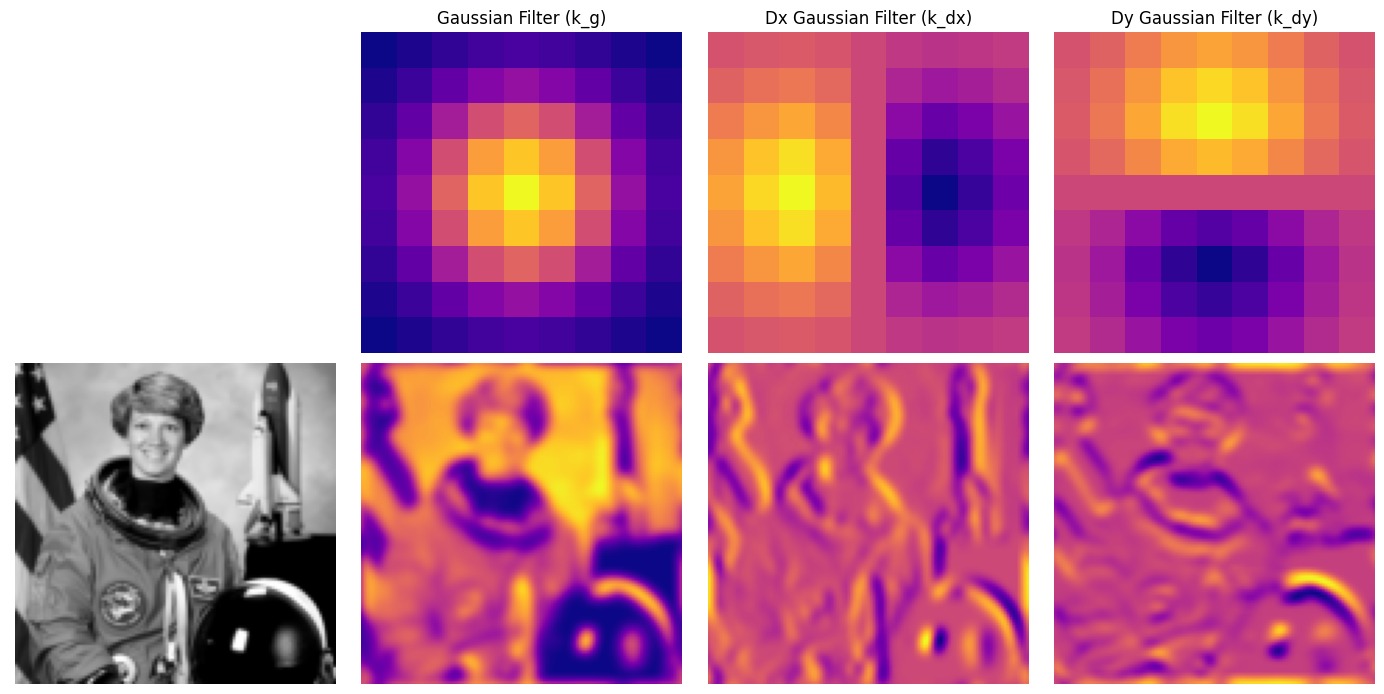

In [4]:
def fspecial_gaussian(sigma=1, k=None):
  
  if k is None:
    k = np.ceil(4*sigma) // 2 * 2 + 1 # make a big-enough odd-sized kernel

  dom = np.arange(k) - (k-1)/2
  [xx,yy] = np.meshgrid(dom,dom)

  kernel = np.exp(-(xx*xx + yy*yy) / (2*sigma*sigma))
  kernel = kernel / kernel.sum()

  return kernel

# NOTE: these filters may appear upside down or backwards, but they are correct
#       for use with convolve2d.
def fspecial_dx_gaussian(sigma=1, k=None):
  kernel = fspecial_gaussian(sigma=sigma, k=k)
  kernel = convolve2d(kernel, np.array([1,0,-1]).reshape(1,3), mode='same', boundary="fill")
  return kernel

def fspecial_dy_gaussian(sigma=1, k=None):
  kernel = fspecial_gaussian(sigma=sigma, k=k)
  kernel = convolve2d(kernel, np.array([1,0,-1]).reshape(3,1), mode='same', boundary="fill")
  return kernel

sigma = 2
k_g = fspecial_gaussian(sigma)
k_dx = fspecial_dx_gaussian(sigma)
k_dy = fspecial_dy_gaussian(sigma)

fig, axs = plt.subplots(2,4, figsize=(14,7))
axs[0,1].imshow(k_g, cmap=C_KE)
axs[0,1].set_title('Gaussian Filter (k_g)')
axs[0,2].imshow(k_dx, cmap=C_KE)
axs[0,2].set_title('Dx Gaussian Filter (k_dx)')
axs[0,3].imshow(k_dy, cmap=C_KE)
axs[0,3].set_title('Dy Gaussian Filter (k_dy)')

IM_SIZE = 115
im = rgb2gray(img_as_float32(data.astronaut()))
im = resize(im, [IM_SIZE, IM_SIZE])

im2 = img_as_float32(data.brick())
im2 = resize(im2, [IM_SIZE, IM_SIZE]) # make smaller and grayscale

axs[0,0].axis("off");
axs[1,0].imshow(im,cmap=C_IM);
axs[1,1].imshow(convolve2d(im, k_g, boundary='wrap', mode="same"), cmap=C_IMf)
axs[1,2].imshow(convolve2d(im, k_dx, boundary='wrap', mode="same"), cmap=C_IMf)
axs[1,3].imshow(convolve2d(im, k_dy, boundary='wrap', mode="same"), cmap=C_IMf);

for ax_i in axs.flat: ax_i.axis('off')
plt.tight_layout()

# Part 1: Separable Convolutions

## Aside: Approximating Images Using the Singular Value Decomposition

You can use the [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD, `np.linalg.svd`) to construct low-rank approximation of images. The SVD is similar to an eigenvalue decomposition, but allows for non-square and non-symmetric matrices. It's used frequently in computer vision for solving homogenous systems, among other uses.

In this short demonstration, we are showing various low-rank approximations for two different images. This is similar to how the JPEG compression uses the DCT basis for image compression and the use of the Fourier basis for frequency domain analysis. The key difference here is that the basis is learned to be optimal for each image as opposed to being a fixed basis that we use as an alternative representation of the image.

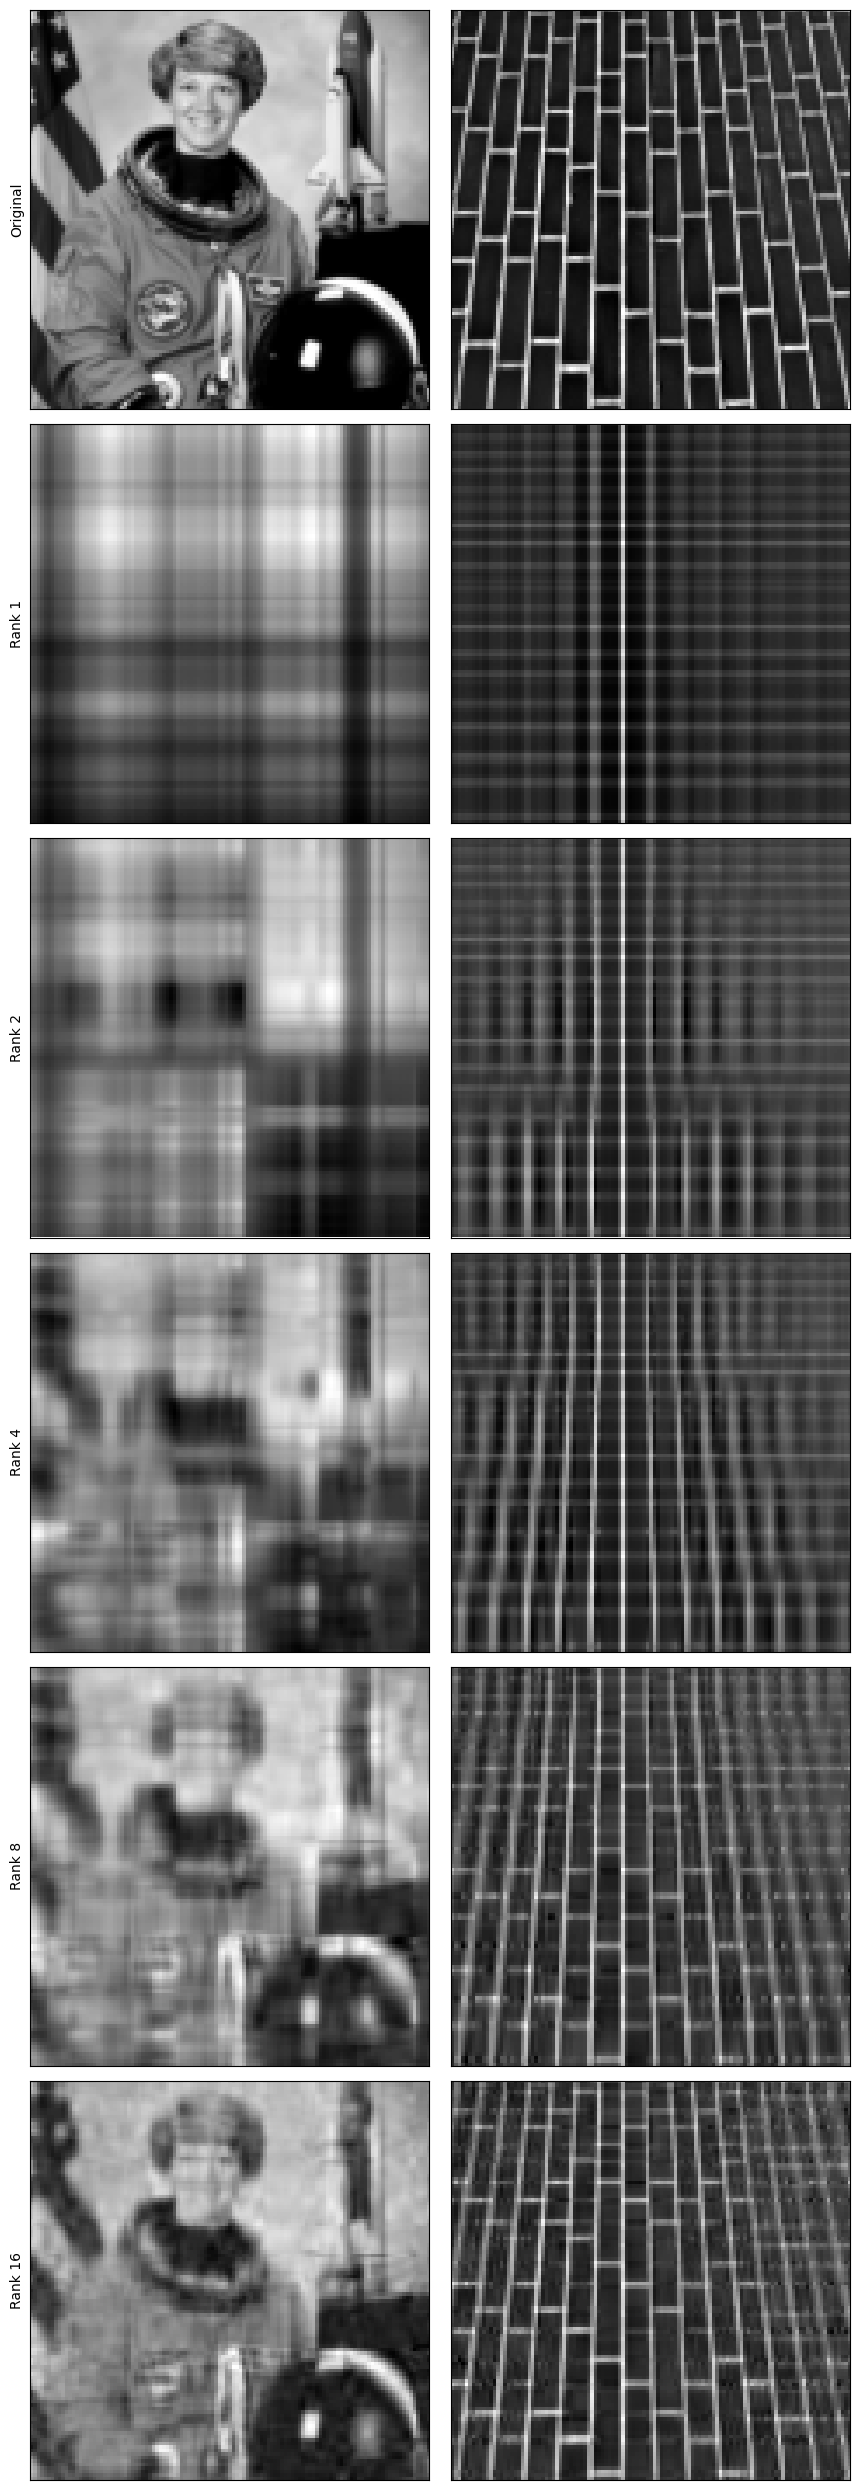

In [5]:
fig, axs = plt.subplots(6,2, figsize=(9,25))

for ix, imt in enumerate([im, im2]):
  
  axs[0,ix].imshow(imt, cmap=C_IM)
  axs[0,0].set_ylabel('Original')

  # solve for the SVD
  U, S, Vt = np.linalg.svd(imt);

  for jx, rank in enumerate([1,2,4,8,16]):
    
    # construct the low-rank image approximation
    keep = np.arange(rank);
    imt_lowrank = U[:,keep] @ np.diag(S[keep]) @ Vt[keep,:]

    axs[jx+1,ix].imshow(imt_lowrank, cmap=C_IM)
    axs[jx+1,0].set_ylabel(f'Rank {rank}')

for ax_i in axs.flat: ax_i.set_xticks([]), ax_i.set_yticks([])
plt.tight_layout()

## TASK: Finding Separable Kernels

You can use the SVD to find two 1D kernels that, when applied successively, are equivalent to a given 2D kernel.

The process is as follows:

1. Compute the SVD of the kernel matrix, $K = U S V^\mathsf{T} = K$.
  - The columns of $U$ contain orthogonal unit vectors.
  - The rows of $V^\mathsf{T}$ contain orthgonal unit vectors.
  - The matrix of singular values, $S$ is diagonal. Typically these are sorted, which imposes some structure on the order $U$ and $V$.
2. Compute the best rank-1 approximation of $K$ as follows:
  - Select the column $U_1$ of $U$ and the row $V^\mathsf{T}_1$ of $V^\mathsf{T}$ the correspond to the largest value $S_1$ in $S$.
  - You can then use $U_1S_1$ as one kernel and $V_1$ as the other

Your task is to implement this to automatically find two 1D kernels that are equivalent to a single 2D kernel. 

**If you do this correctly**, you should see that the output of the separable convolution and the regular convolution is identical, up to minor differences due to numerical precision. 

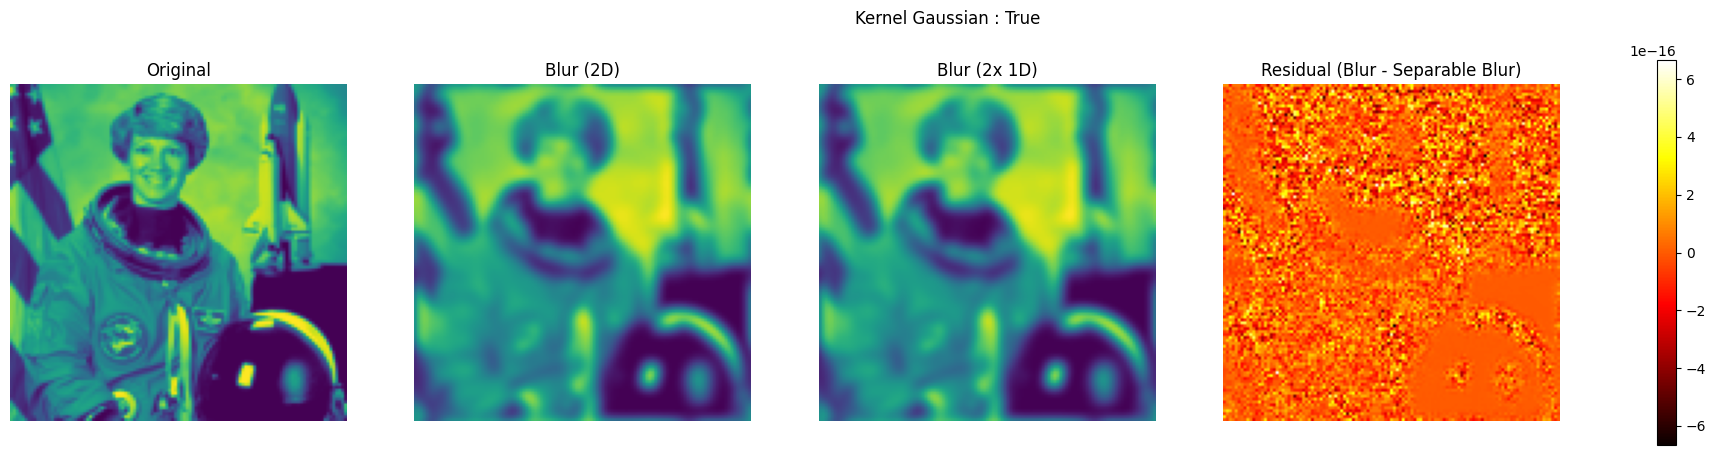

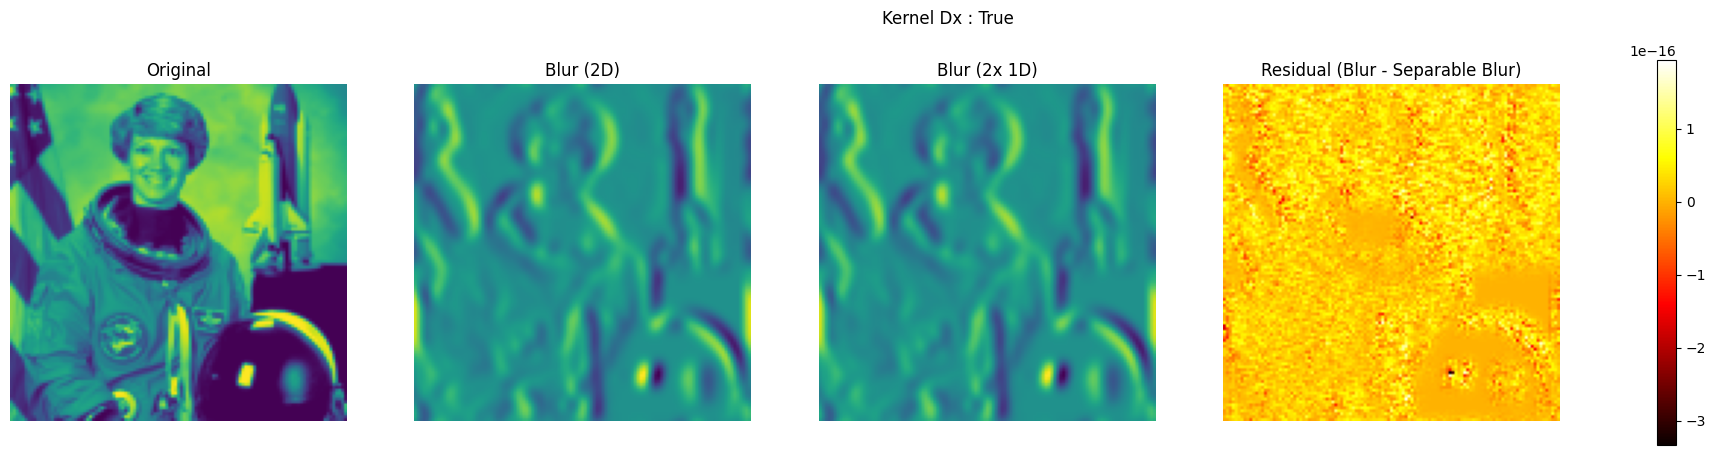

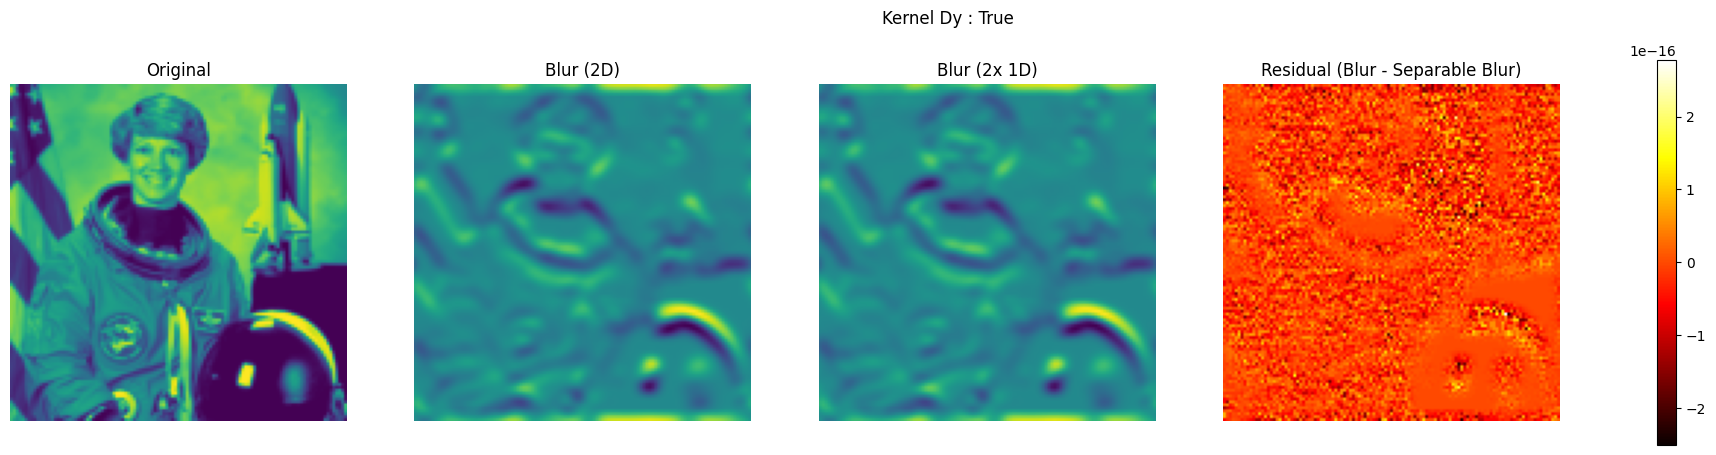

In [6]:
def separate_kernel(kernel):

  ### YOUR CODE BELOW HERE
  U, s, Vt = np.linalg.svd(kernel)
  # Ensure the kernel is separable (only one significant singular value)
  assert np.allclose(s[1:], 0, atol=1e-6), "Kernel is not separable"
  # Extract the first singular vectors and scale by sqrt(s[0])
  kv = U[:, 0] * np.sqrt(s[0])
  kh = Vt[0, :] * np.sqrt(s[0])
  kv = kv.reshape(-1, 1)  # Reshape to column vector
  kh = kh.reshape(1, -1)  # Reshape to row vector
  ### YOUR CODE ABOVE HERE

  assert 1 == np.sum(~np.isclose(0,s)), "The kernel does not appear to be separable"
  assert np.allclose(kv@kh, kernel), 'The product of the separable kernels does not match the source kernel'

  return kv, kh

def convolve2d_sep(im, kernel):
  kv, kh = separate_kernel(kernel)
  im_blur_tmp = convolve2d(im, kv, boundary='wrap', mode="same")
  im_blur_tmp = convolve2d(im_blur_tmp, kh, boundary='wrap', mode="same")
  return im_blur_tmp

for name, kernel in zip("Gaussian Dx Dy".split(" "), [k_g, k_dx, k_dy]):
  
  im_blur = convolve2d(im,kernel, boundary='wrap', mode="same")
  im_blur_sep = convolve2d_sep(im, kernel)

  fig, axs = plt.subplots(1,4, figsize=(25,5))

  axs[0].imshow(im)
  axs[0].set_title('Original')
  axs[0].axis('off')

  axs[1].imshow(im_blur)
  axs[1].set_title('Blur (2D)')
  axs[1].axis('off')

  axs[2].imshow(im_blur_sep)
  axs[2].set_title('Blur (2x 1D)')
  axs[2].axis('off')

  dif = axs[3].imshow(im_blur - im_blur_sep, cmap="hot")
  axs[3].set_title('Residual (Blur - Separable Blur)')
  axs[3].axis('off')
  fig.colorbar(dif, ax=axs)
  
  fig.suptitle(f"Kernel {name} : {np.allclose(im_blur, im_blur_sep)}")

## Why should we care about separable convolutions?

There are two main reasons:

1. If a kernel is separable, then we can represent the same transformation with significantly fewer parameters ($O(DW)$ as opposed to $O(W^D)$ where D is the number of dimensions and $W$ is the width of the kernel). This is especially true as we extend to higher dimensionsal kernels, such as a 3D kernel that would be applied to video. Also, even if a kernel is not perfectly separable, it may still be reasonable to approximate it as a separable kernel.
1. It may be faster to apply multiple 1D kernels convolutional rather than a single full kernel.

We can see that in the following cell, which computes separable and regular convolutions for different filter sizes. In my instance, we start seeing noticeable differences at a kernels size of $13\times13$ (almost a $3\times$ speedup).

In [7]:
# this is slow, so only run it once
# TODO make this True in the starter but False in the solution
if False and 'FIRST_TIME' not in locals():

  FIRST_TIME = False

  for sigma_t in [1,3,5,7,9,11]:
    k_tmp = fspecial_gaussian(sigma_t)

    print('==================================================')
    print(f'Kernel Shape : {k_tmp.shape}')
    print(f'Convolution with a single **full** kernel (sigma={sigma_t}):')
    %timeit convolve2d(im, k_tmp)

    print(f'Convolution with separable kernels (sigma={sigma_t}):')
    %timeit convolve2d_sep(im, fspecial_gaussian(sigma_t));
else:
  print('Skipping to save time.')

Skipping to save time.


# Part 2: Fourier Domain Image Filtering

In this part, we'll look at the frequency domain image representation and show how the Fourier convolution theorem works. 

Recall that the Fourier convolution theorem states that convolution in the spatial domain $B = A \ast K$ is equal to point-wise multiplication (the Hadamard product) in the frequency domain: $F(B) = F(A) \odot F(K)$, where $F(\dot)$ is the Fourier transform (FFT). This means we can recover $B = F^{-1}(F(B))$.


# Implementation Issues

When implementing Fourier-based convolution in Numpy, we need to be careful about the definition of the FFT functions. We'll be using those defined in `numpy.fft`. There are several important notes:
1. There are two key functions: `fft2`, which is equivalent to $F(\dot)$, and `ifft2`, which is equivalent to $F^{-1}(\dot)$.
1. Both of these functions assume the origin is in the upper left corner of the image. This requires two steps: 
   - Use `ifftshift` prior to calling `fft2` to bring the center of the image/kernel to the right location. In other words, you should use the following `K_fft = fft2(ifftshift(K))` to compute the FFT of the kernel, $K$.
  - Use `fftshift` prior to displaying the spectrum. In other words, you should use the following `fftshift(K_fft)` prior to displaying the FFT (this isn't strictly required, but it's the standard way we display the spectrum, with the low-frequency terms in the middle.
1. The result of `fft2` will be a complex number. Typically this is displayed with something like: `np.log(np.abs(K_fft)+1)`, where the `np.abs` computes the magnitude of the complex number, the `np.log` ensures that the display is not dominated by one large value, and the `+1` avoids the problem of taking the log of zero.
1. The result of `ifft2` is also a complex number. You should apply `.real` to convert the image into something you can display.

See below for some examples.

### Shifting Matters

Here we demonstrate that properly using `fftshift` and `ifftshift` is important. In general, we will apply `ifftshift` to inputs before calling `fft2` and `fftshift` prior to displaying the output of either `fft` or `ifft2`.

In [8]:

k_g_fft = fft2(ifftshift(k_g)) # compute the FFT the right way
k_g_fft_wrong = fft2(k_g) # compute the FFT the wrong way

k_g_recon = fftshift(ifft2(k_g_fft)).real # reconstruct from the "right way" FFT
k_g_recon_wrong = ifft2(k_g_fft_wrong).real # reconstruct the kernel from the "wrong way" FFT

# Notice that both reconstructions are correct
print(np.allclose(k_g, k_g_recon))
print(np.allclose(k_g, k_g_recon_wrong))

# Notice that the frequency domain representations are different! This should
# make it clear that this will result in a different output when used to compute
# a convolution using the FFT.
print(np.allclose(k_g_fft, k_g_fft_wrong))


True
True
False


### Example Spectra

Here we show some additional examples that visualize the FFT spectra, and the use of `ifftshift` and `fftshift` for an image and a kernel.

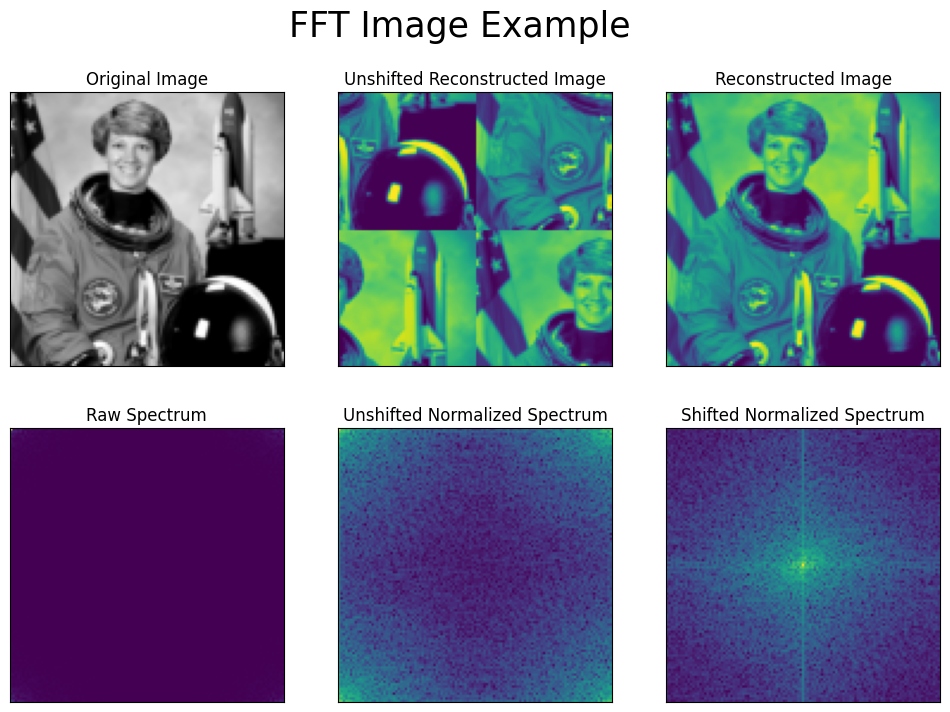

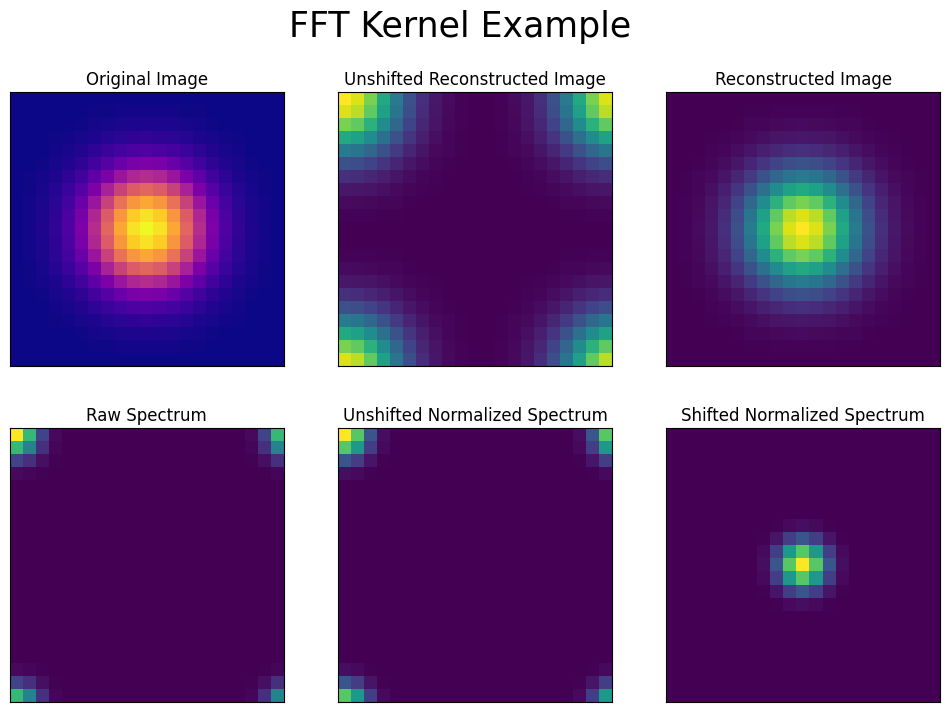

In [9]:
def show_fft(arr, cmap=C_IM, title=None):

  F_im = fft2(ifftshift(arr))

  F_spectrum_mag = np.abs(F_im)
  F_spectrum_disp = np.log(F_spectrum_mag+1)
  F_im_recon = np.abs(ifft2(F_im))

  fig,axs = plt.subplots(2,3, figsize=(12,8))

  axs[0,0].imshow(arr, cmap=cmap);
  axs[0,0].set_title('Original Image')
  axs[0,1].imshow(F_im_recon, cmap=C_FFT);
  axs[0,1].set_title('Unshifted Reconstructed Image')
  axs[0,2].imshow(fftshift(F_im_recon), cmap=C_FFT);
  axs[0,2].set_title('Reconstructed Image')

  axs[1,0].imshow(F_spectrum_mag, cmap=C_FFT);
  axs[1,0].set_title('Raw Spectrum')
  axs[1,1].imshow(F_spectrum_disp, cmap=C_FFT);
  axs[1,1].set_title('Unshifted Normalized Spectrum')
  axs[1,2].imshow(fftshift(F_spectrum_disp), cmap=C_FFT);
  axs[1,2].set_title('Shifted Normalized Spectrum')

  for ax_i in axs.flat: ax_i.set_xticks([]), ax_i.set_yticks([])
  
  fig.suptitle(title, fontsize=25)

show_fft(im, title="FFT Image Example")

show_fft(fspecial_gaussian(3, k=21), cmap=C_KE, title="FFT Kernel Example")


## How big is big enough?

One way to understand the effect of a particular convolution is to see it's frequency domain response. Here we show several things:

1. The frequence response of a Gaussian kernel is a Gaussian in the frequency domain. This means that high frequency responses are multiplied by a small number and hence are removed from the image.
1. When the kernel is too small for the standard deviation of the Guassian, we see high-frequency regions that do not have small numbers. This leads to high-frequency details being apparent in the output image when the kernel is applied.

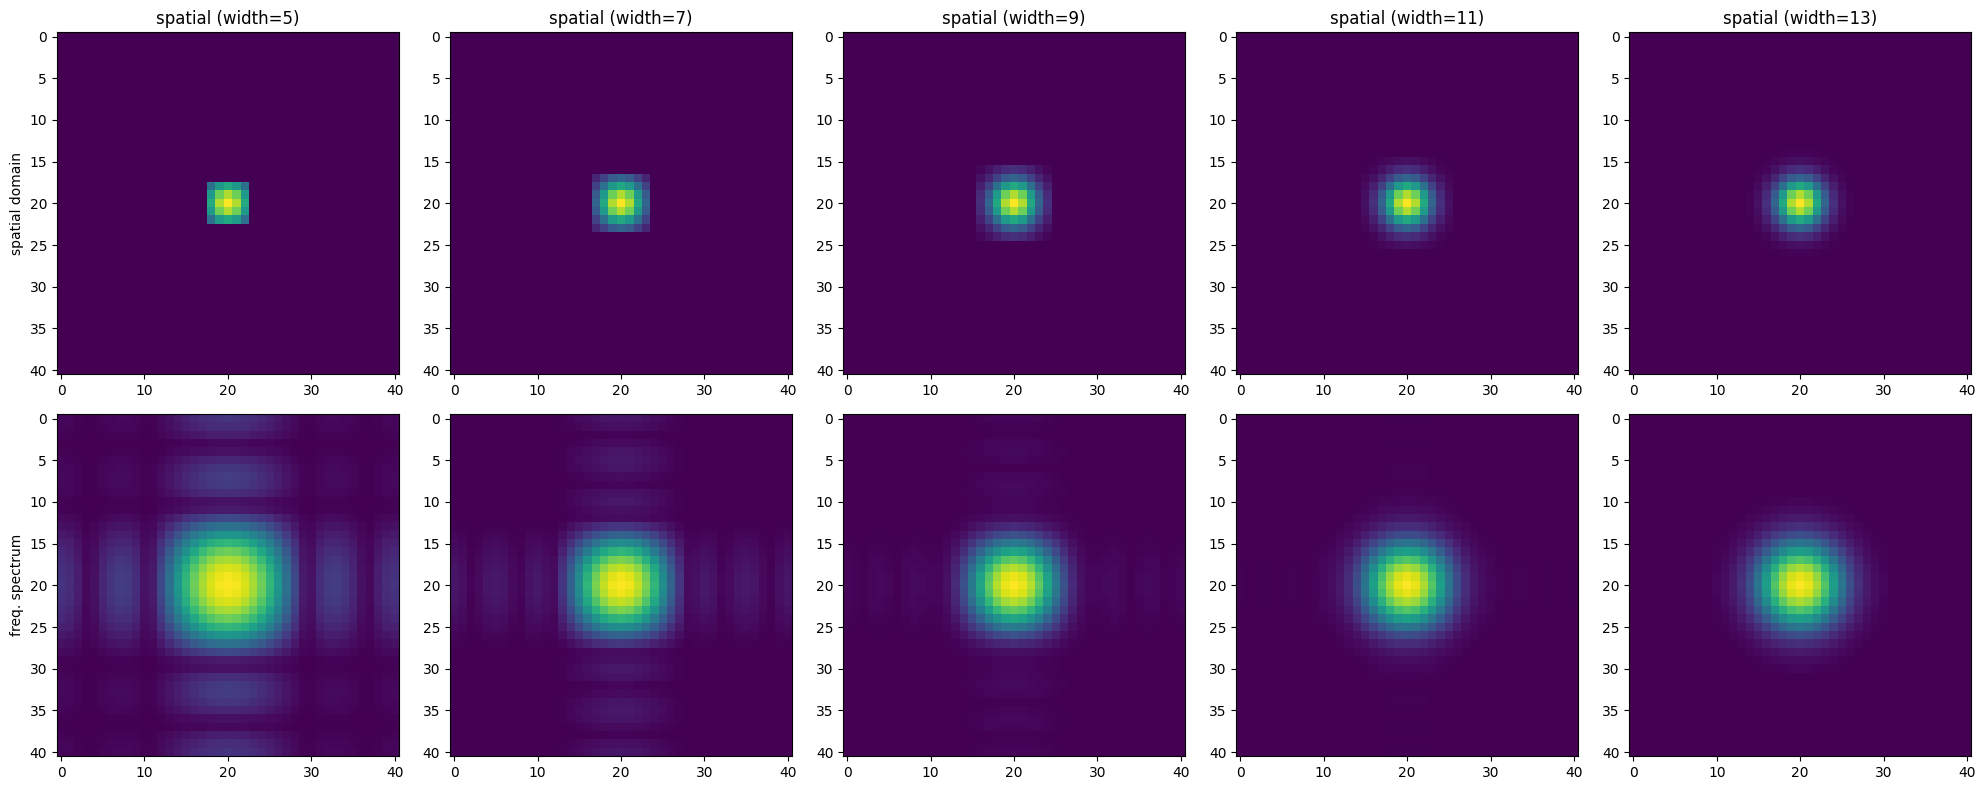

In [10]:
def show_impact_of_kernel_width():
  target_size = (41,41)

  fig,axs = plt.subplots(2,5, figsize=(20,8))

  for i, width in enumerate(range(5,15,2)):
    
    kernel = fspecial_gaussian(2, k=width)

    # pad kernel w/ zeros to a fixed size
    p1, p2 = (np.array(target_size)-kernel.shape).astype(int)//2                                                                                                                              
    kernel = np.pad(kernel, ((p1,p1), (p2,p2)), mode="constant")

    kernel_fft = fftshift(fft2(ifftshift(kernel)))

    axs[0,i].imshow(kernel)
    axs[0,0].set_ylabel("spatial domain")
    axs[0,i].set_title(f"spatial (width={width})")
 
    axs[1,i].imshow(np.log(1+np.abs(kernel_fft)))
    axs[1,0].set_ylabel("freq. spectrum")
    plt.tight_layout()

show_impact_of_kernel_width()


## Task: Implement 2D convolution using the FFT.

You will implement a 2D convolution using the Fourier convolution theorem. You may use the available functions: `fft2`, `ifft2`, `fftshift`, `ifftshit`, and numpy array multiplication (not matrix multiplication!).


**If you do this correctly**, you should see that the output of the FFT convolution and the regular convolution is identical, up to minor differences due to numerical precision (likely $|e| < 1^{-8}$, where $e$ is the residual error). 

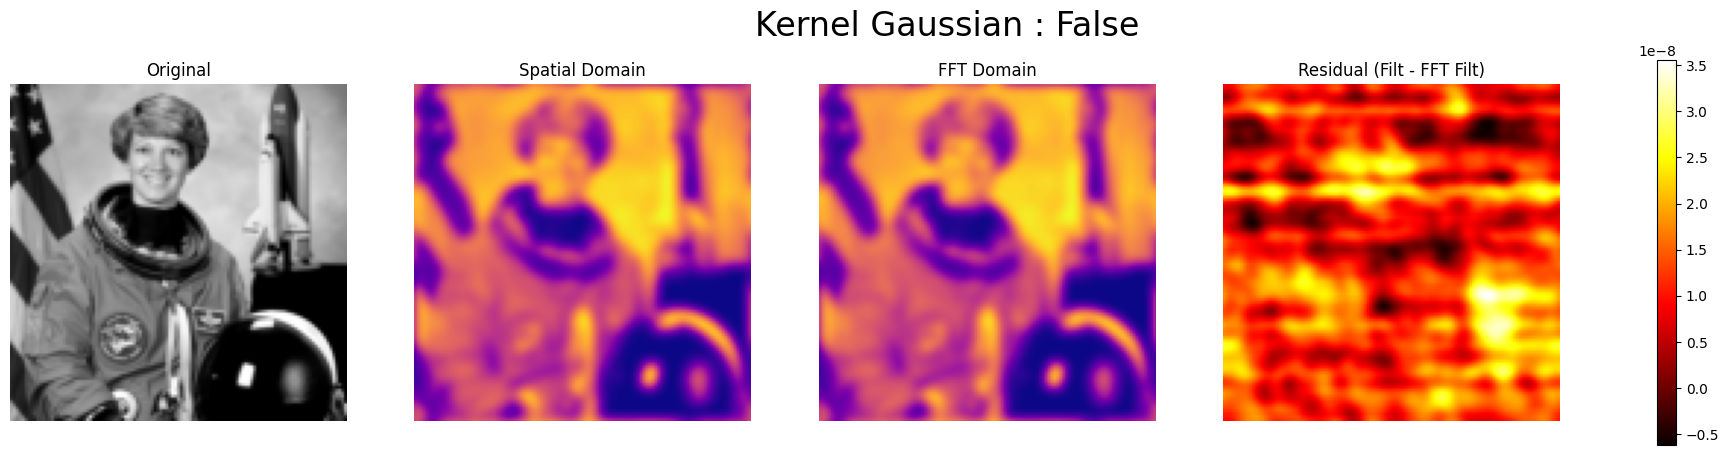

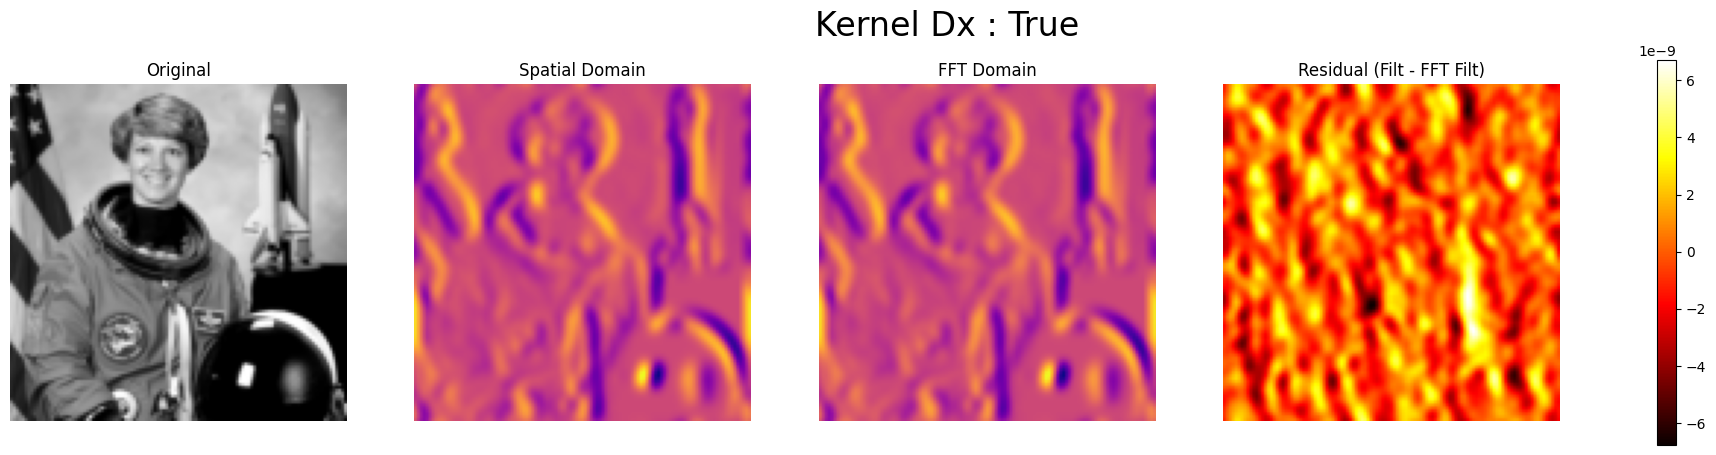

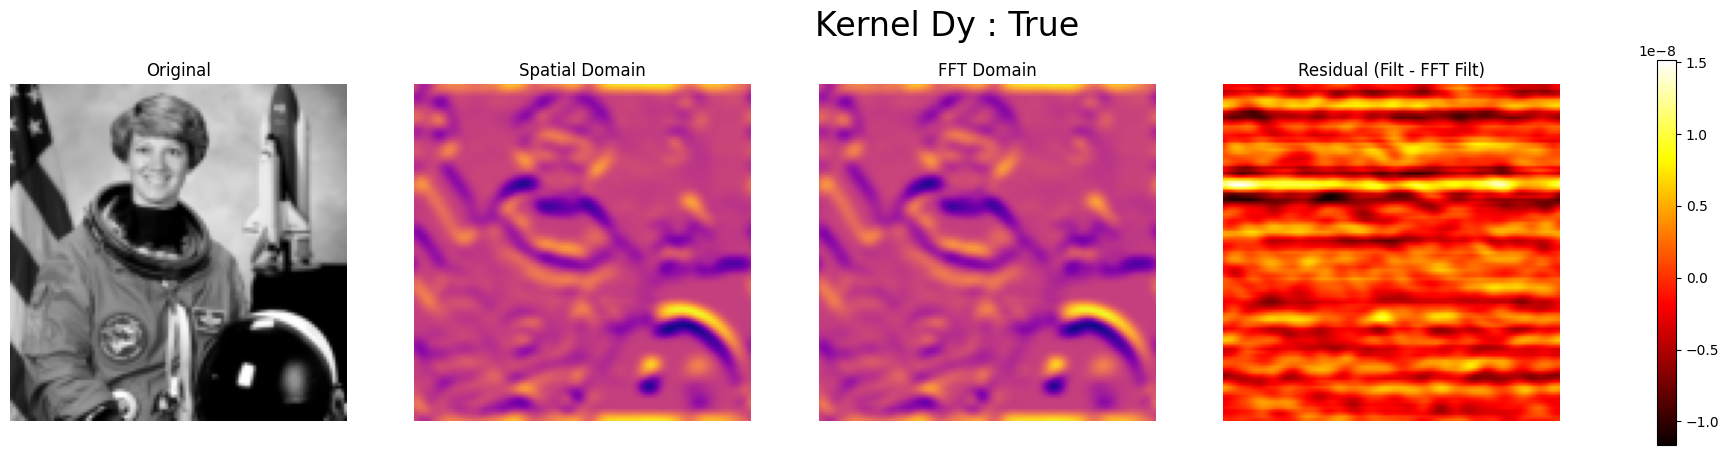

In [11]:

def fftconvolve_mine(im, kernel):
  
  # pad the kernel so it's the same size as the input image
  p1, p2 = (np.array(im.shape)-kernel.shape).astype(int)//2                                                                                                                              
  kernel = np.pad(kernel, ((p1,p1), (p2,p2)), mode="constant")

  ### YOUR CODE BELOW HERE
  im_fft = fft2(ifftshift(im))
  kernel_fft = fft2(ifftshift(kernel))
  
  product_fft = im_fft * kernel_fft
  im_blur_fft = fftshift(ifft2(product_fft))
  ### YOUR CODE ABOVE HERE

  return im_blur_fft.real

for name, kernel in zip("Gaussian Dx Dy".split(" "), [k_g, k_dx, k_dy]):
  
  im_filt = convolve2d(im,kernel, boundary='wrap', mode="same")
  im_filt_fft = fftconvolve_mine(im, kernel)

  fig, axs = plt.subplots(1,4, figsize=(25,5))

  axs[0].imshow(im, cmap=C_IM)
  axs[0].set_title('Original')
  axs[0].axis('off')

  axs[1].imshow(im_filt, cmap=C_IMf)
  axs[1].set_title('Spatial Domain')
  axs[1].axis('off')

  axs[2].imshow(im_filt_fft, cmap=C_IMf)
  axs[2].set_title('FFT Domain')
  axs[2].axis('off')

  dif = axs[3].imshow(im_filt - im_filt_fft, cmap="hot")
  axs[3].set_title('Residual (Filt - FFT Filt)')
  axs[3].axis('off')
  fig.colorbar(dif, ax=axs)
  
  fig.suptitle(f"Kernel {name} : {np.allclose(im_filt, im_filt_fft)}", fontsize=24)



# Part 3: Optical Flow


In [12]:
#@title Optical Flow Visualization Code

def show_alignment(im1, im2, flow):
  NR, NC = im1.shape
  row_coords, col_coords = np.meshgrid(np.arange(NR), np.arange(NC), indexing='ij')
  im2_warp = warp(im2, np.array([row_coords + flow[:,:,1], col_coords + flow[:,:,0]]), mode='edge')

  # build an RGB image with the unregistered sequence
  seq_im = np.tile(im1[:,:,None], [1,1,3])
  seq_im[..., 0] = im2

  # build an RGB image with the registered sequence
  reg_im = np.tile(im1[:,:,None], [1,1,3])
  reg_im[..., 0] = im2_warp

  # build an RGB image with the registered sequence
  target_im = np.tile(im1[:,:,None], [1,1,3])

  fig, axs = plt.subplots(1, 3, figsize=(12, 5))

  axs[0].imshow(seq_im)
  axs[0].set_title("Unregistered sequence")

  axs[1].imshow(reg_im)
  axs[1].set_title("Registered sequence")

  axs[2].imshow(target_im)
  axs[2].set_title("Target")
  plot_quiver(axs[2], flow, 2, margin=0, color='red')

  for ax in axs.flat: ax.set_axis_off()
  fig.tight_layout()

  return im2_warp


## Constructing synthetic flow examples

We make three simple examples with image motion. Note that these could be solved by assuming a single global flow, but we'll solve these using local optical flow estimates.

In [14]:
imt = downscale_local_mean(img_as_float32(data.camera()), (16,16))

# shift image left by one
A1 = imt[:,:-1]
A2 = imt[:,1:]

# shift image up by one
B1 = imt[:-1,:]
B2 = imt[1:,:]

# shift image up and left by one
C1 = imt[:-1,:-1]
C2 = imt[1:,1:]

mp.show_video([.5*np.ones_like(A1), A1, A2], fps=1, height=256, title='Image Pair A')
mp.show_video([.5*np.ones_like(B1), B1, B2], fps=1, height=256, title='Image Pair B')
mp.show_video([.5*np.ones_like(C1), C1, C2], fps=1, height=256, title='Image Pair C')

RuntimeError: Program 'ffmpeg' is not found; perhaps install ffmpeg using 'apt install ffmpeg'.

## Using optical flow to align the image pairs

Here we use an `skimage` optical flow function to calculate the optical flow between all pairs of images. This function uses a variety of approaches to achieve accurate flow estimates. Below you will estimate optical flow without using all the tricks and the result won't be quite as good. 

To visualize the flow, we are using a special visualization technique. We first make a three-channel all-gray version of the first image. We then replace the red channel with the second image (left). Areas where there is change in the scene will show up as different colors. We then warp the second image using the flow and replace the red channel with the warped image (middle). If the warp is accurate, this should look like a gray image again. We also show the flow vectors (right).

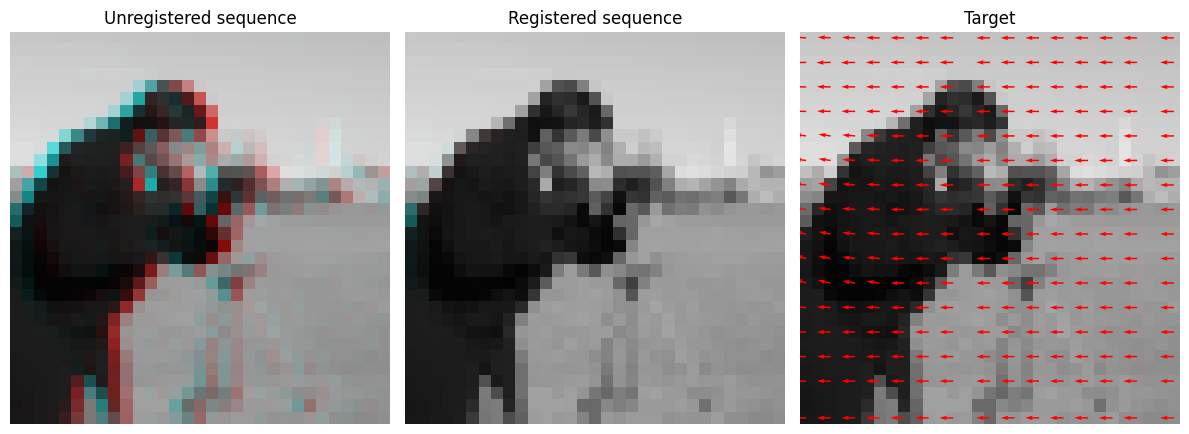

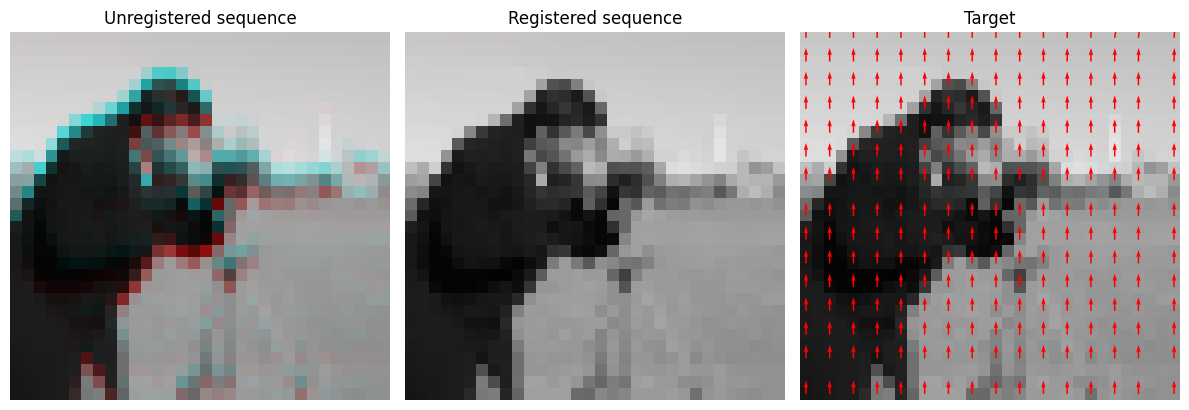

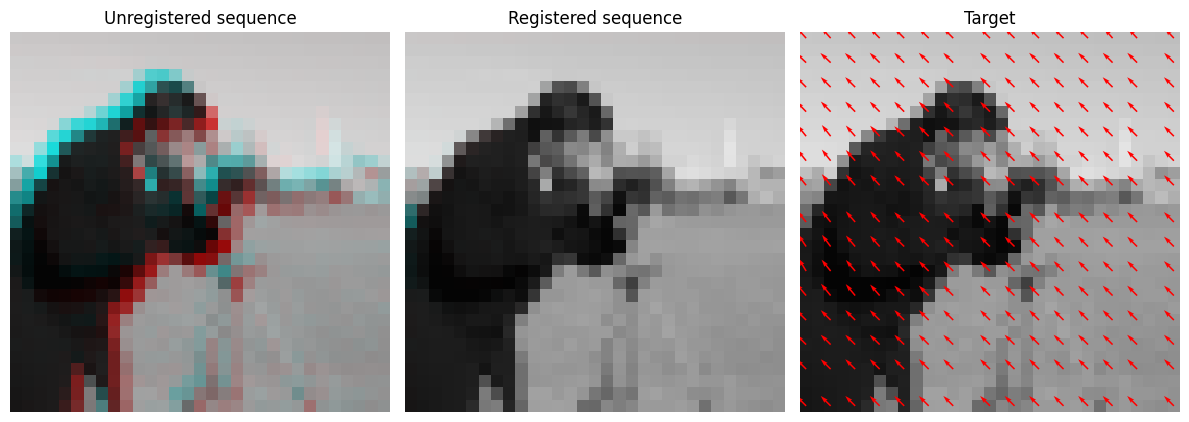

In [15]:
def fix_skflow(flow):
  # switching to "channels last" and x,y layout for flow
  # by default it's in channels first" and i,j layout
  flow = flow.transpose([1,2,0])
  return flow[:,:,::-1]

flow_A = optical_flow_ilk(A1, A2)
flow_A = fix_skflow(flow_A)
A2_warp = show_alignment(A1,A2,flow_A)

flow_B = optical_flow_ilk(B1, B2)
flow_B = fix_skflow(flow_B)
B2_warp = show_alignment(B1,B2,flow_B)

flow_C = optical_flow_ilk(C1, C2)
flow_C = fix_skflow(flow_C)
C2_warp = show_alignment(C1,C2,flow_C)

## An alternative alignment visualization

Here we visualize the registration by rapidly flipping between the target image and the warped source image. 

In [16]:
def show_videos(im1, im2, im2_warp, name):

  vids = {
      f"{name} (Unregistered)":(im1, im2), 
      f"{name} (Registered)":(im1,im2_warp)
      }

  mp.show_videos(vids, fps=5, height=256)

show_videos(A1, A2, A2_warp, 'Video A')
show_videos(B1, B2, B2_warp, 'Video B')
show_videos(C1, C2, C2_warp, 'Video C')

RuntimeError: Program 'ffmpeg' is not found; perhaps install ffmpeg using 'apt install ffmpeg'.

## Task: Write a simple optical flow function

Write a simple optical flow function using only convolutional operations, basic array manipulation, and `np.lingalg.solve`. Recall that to estimate optical flow we need to solve the following equation for $V_x,V_y$:
$$
A \begin{bmatrix}
V_x\\[10pt]
V_y
\end{bmatrix} = B
$$
where
$
A = \begin{bmatrix}
\sum_i W(q_i)I_x(q_i)^2 & \sum_i W(q_i)I_x(q_i)I_y(q_i) \\[10pt]
\sum_i W(q_i)I_y(q_i)I_x(q_i) & \sum_i W(q_i)I_y(q_i)^2 
\end{bmatrix}
$ and $B = 
\begin{bmatrix}
-\sum_i W(q_i) I_x(q_i)I_t(q_i) \\[10pt]
-\sum_i W(q_i) I_y(q_i)I_t(q_i)
\end{bmatrix}
$.

In the previous cell, the `skimage` optical flow implementation resulted in nearly perfect alignment. This can be seen in the very small number of of non-gray pixels in the middle column. With your implementation, you should see 

Notes: 

1. You do not need to implement multi-scale optical flow. All you need to do is use the provided gradients to estimate the optical flow.
1. Your solution should result in a significant improvement in the alignment (much fewer colored pixels in the middle column than in the left column), but will likely not be as good as the `skimage` implementation above.

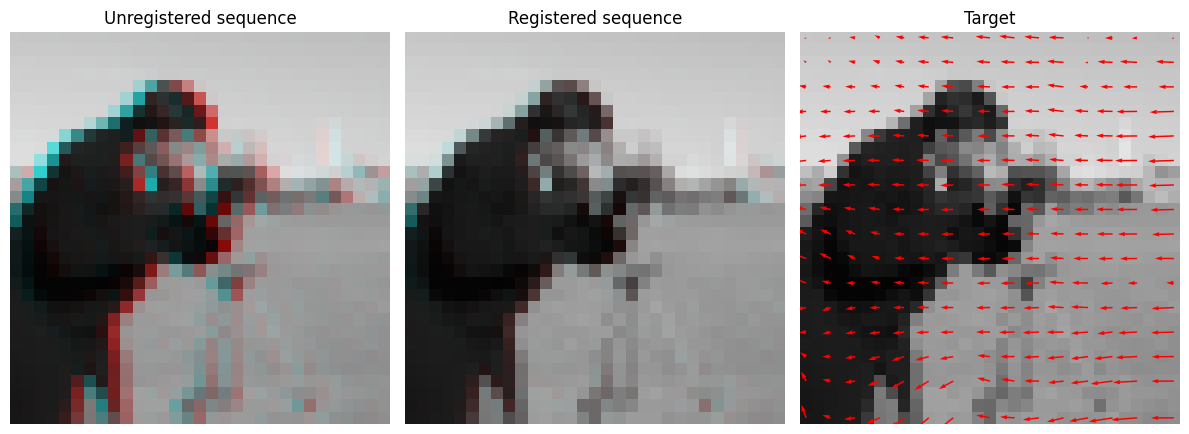

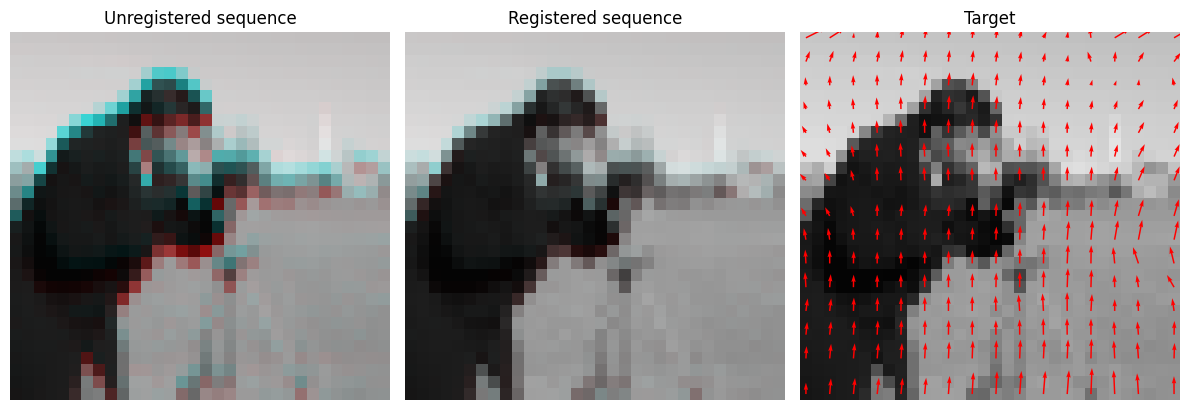

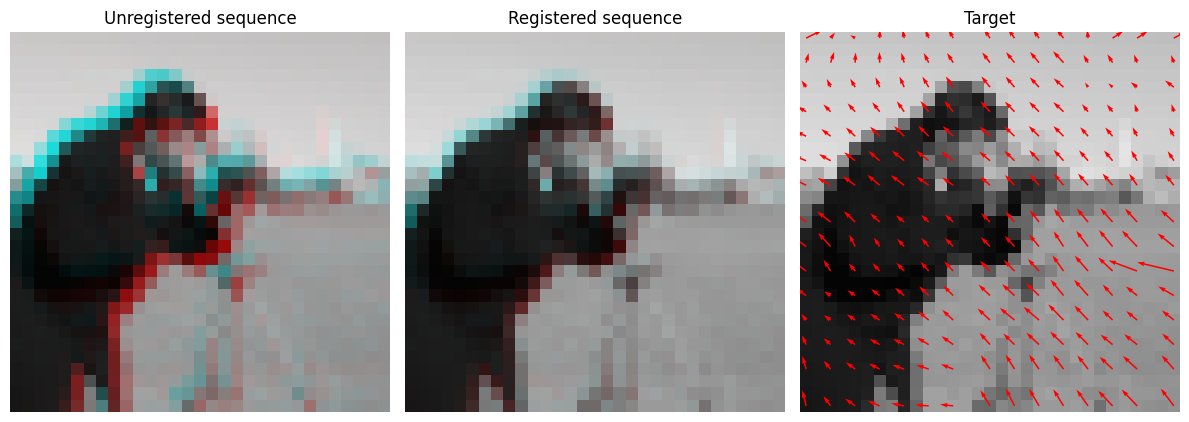

In [17]:

def optical_flow(im1, im2, sigma=5):

  assert im1.shape == im2.shape, "im1 and im2 must be the same shape"

  def conv(arr, kernel):
    return convolve2d(arr, kernel, mode='same', boundary="symm")

  kernel_dx = fspecial_dx_gaussian(1)
  kernel_dy = fspecial_dy_gaussian(1)
  kernel_window = fspecial_gaussian(3)

  # estimate the image derivatives
  Ix = conv(im2, kernel_dx)
  Iy = conv(im2, kernel_dy)
  It = im2-im1

  ### YOUR CODE BELOW HERE

  # use the image derivative estimates defined above, and the local 
  # function `conv` with `kernel_window` to accumulate the local gradient
  # information

  # 1) construct an array A_all to hold the second moment matrices for every pixel
  #    the first two dimensions should be height x width and the last two should
  #    hold the second moment matrix

  # 2) construct an array B_all to hold the B values for every pixel
  #    the first two dimensions should be height x width and the last should hold the
  #    values from B
  Ix2 = conv(Ix**2, kernel_window)
  Iy2 = conv(Iy**2, kernel_window)
  IxIy = conv(Ix*Iy, kernel_window)
  IxIt = conv(Ix*It, kernel_window)
  IyIt = conv(Iy*It, kernel_window)
  
  H, W = im2.shape
  A_all = np.zeros((H, W, 2, 2))
  B_all = np.zeros((H, W, 2))
  
  A_all[..., 0, 0] = Ix2
  A_all[..., 0, 1] = A_all[..., 1, 0] = IxIy
  A_all[..., 1, 1] = Iy2
  B_all[..., 0] = -IxIt
  B_all[..., 1] = -IyIt
  ### YOUR CODE ABOVE HERE

  assert A_all.shape == im2.shape + (2,2), f'A_all should have shape {im2.shape + (2,2)} but is {A_all.shape}.'
  assert B_all.shape == im2.shape + (2,), f'B_all should have shape {im2.shape + (2)} but is {B_all.shape}.'

  H, W = im2.shape
  flow = np.zeros((H, W, 2), dtype=np.float32)

  for i in range(H):
      for j in range(W):
          A = A_all[i, j]
          B = B_all[i, j]
          try:
              flow[i, j] = np.linalg.solve(A, B)
          except np.linalg.LinAlgError:
              flow[i, j] = 0  # fallback if singular

  return flow

flow_A = optical_flow(A1,A2)
A2_warp = show_alignment(A1,A2,flow_A)

flow_B = optical_flow(B1,B2)
B2_warp = show_alignment(B1,B2,flow_B)

flow_C = optical_flow(C1,C2)
C2_warp = show_alignment(C1,C2,flow_C);


## Dynamic registration visualization

In [ ]:
show_videos(A1, A2, A2_warp, 'Video A')
show_videos(B1, B2, B2_warp, 'Video B')
show_videos(C1, C2, C2_warp, 'Video C')

# Submission Guide
Follow [this canvas page](https://wustl.instructure.com/courses/100902/pages/homework-submission-workflow) for detailed submission guidelines.

# Credits
Assignment developed by Nathan Jacobs based on a similar project by James Hays, which was based on a similar project by Derek Hoiem.

# AI Usage Summary

[as per course policy, we allow the use of AI assistants as part of completing homework assignments, however such usage must be acknowledged. If it is detected and not acknowledged, it will be considered a violation of academic integrity. As such, please summarize what AI tools you used to complete this assignment, including for understanding the concepts and generating source code. If you used code generation, please explain the extent to which you had to modify the solution for it to function correctly.]